In [ ]:
# default_exp model.cvae
#default_cls_lvl 3

In [ ]:
# export
from snkrfinder.imports import *
from snkrfinder.core import *
from snkrfinder.data.core import *
from snkrfinder.model.core import *
#from snkrfinder.model.transfer import *

from fastai.test_utils import show_install, synth_learner, nvidia_smi, nvidia_mem

In [ ]:
#hide
from nbdev.showdoc import *

# first snkrfinder.model.cvae



## OVERVIEW: cvae module - convolutional variational auto encoder

preamble: This is a project initiated while an Insight Data Science fellow.  It grew out of my interest in making data driven tools in the fashion/retail space I had most recently been working.   The original over-scoped idea was to make a shoe desighn tool which could quickly develop some initial sneakers based on choosing some examples, and some text descriptors.  Designs are constrained by the "latent space" defined (discovered?) by a database of shoe images.  However, given the 3 week sprint allowed for development, I pared the tool down to a simple "aesthetic" recommender for sneakers, using the same idea of utilizing an embedding space defined by the database fo shoe images.



### A: Sneaker Image Autoencoder in fastai v2
    - vanilla linear encoder / decoder
    - convolutional (resnet) encoder / decoder

### B: Sneaker Image Variational Autoencoder in fastai v2
    
    - Encoders:  
        - vanilla convolutional bottleneck
        - pretrained encoders
        
    - VAE "bottleneck":  linear encoding of latent space + "reparameterazation trick" linear decoding
    
    - Decoders / generators
        - convTranspose
        - convolutional upsampling blocks (with 

### C: ?? Sneaker Image Variational Autoencoder + GAN in fastai v2
    - GAN finetuning?
    - crappify general pattern


### TODO: model based data cleaning (widget module?)
1. throw out based on inspection of high loss
2. try mixed labels?  things that are >50% sneakers included???



In [ ]:
#hide
show_install()



```text
=== Software === 
python        : 3.8.2
fastai        : 2.2.7
fastcore      : 1.3.19
fastprogress  : 0.2.7
torch         : 1.7.1
nvidia driver : 455.38
torch cuda    : 11.0 / is available
torch cudnn   : 8005 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : GeForce RTX 2070 SUPER

=== Environment === 
platform      : Linux-5.8.0-7630-generic-x86_64-with-glibc2.10
distro        : #32~1609193707~20.10~781bb80-Ubuntu SMP Tue Jan 5 21:29:56 UTC 2
conda env     : fastai
python        : /home/ergonyc/anaconda3/envs/fastai/bin/python
sys.path      : /home/ergonyc/Projects/Project2.0/snkr-finder/nbs
/home/ergonyc/anaconda3/envs/fastai/lib/python38.zip
/home/ergonyc/anaconda3/envs/fastai/lib/python3.8
/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/lib-dynload

/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages
/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg
/home/ergonyc/anaconda3/envs/fastai/lib

In [ ]:
#hide
nvidia_smi()


'Thu Feb 25 22:58:19 2021       \n+-----------------------------------------------------------------------------+\n| NVIDIA-SMI 455.38       Driver Version: 455.38       CUDA Version: 11.1     |\n|-------------------------------+----------------------+----------------------+\n| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |\n| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |\n|                               |                      |               MIG M. |\n|===============================+======================+======================|\n|   0  GeForce RTX 207...  Off  | 00000000:01:00.0 Off |                  N/A |\n|  0%   32C    P8    12W / 215W |   1387MiB /  7979MiB |      0%      Default |\n|                               |                      |                  N/A |\n+-------------------------------+----------------------+----------------------+\n                                                                           

In [ ]:
#hide 
# fix our base directory
print(Path().cwd())
os.chdir(L_ROOT)
print(Path().cwd())

/home/ergonyc/Projects/Project2.0/snkr-finder/nbs
/home/ergonyc/Projects/Project2.0/snkr-finder


## Using  fastai V2: data pipelining
- Datablock API
- check that tfms are applied to input/target
- labeling func: `lambda o: o`

Load the saved merged database, and set the seeds.  And doublecheck our data is where we expect.

In [ ]:

df = pd.read_pickle(f"data/{COMBINED_DF}.pkl")
np.random.seed(3333)
torch.manual_seed(3333)


In [ ]:

image_path = L_ROOT/"data"

batch_size = 64

L([image_path/d for d in df.path])

(#29951) [Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/A. Testoni/7965307.5291.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/A. Testoni/7999255.363731.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/A. Testoni/8000978.364150.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/AIGLE/8113228.1897.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/AIGLE/8113228.1912.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/AIGLE/8113228.3.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/ALDO/8045630.60941.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/ALDO/8045637.3.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/ALDO/8045654.3.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkr-finder/data/Boots/Ankle/ALDO/8045660.3.jpg')...]

In [ ]:
# export

def prep_df_for_datablocks(df):
    df = df[["path","train","test","validate","t_t_v"]].copy()
    # I could remove all the "test" rows... for now i'll choose an alternate strategy:
    # Drop all the "test" rows for now, and create an "is_valid" column...
    # should probably drop a ton of columns to jus tkeep the file paths...
    # just keep what we'll need below
    df.loc[:,'is_valid'] = df.test | df.validate
    return df



In [ ]:
df = prep_df_for_datablocks(df)

In [ ]:
#export

# some helper functions borrowed from validating the feature embedding
def df_get_x(r): 
    return image_path/r['path']

def df_get_y(r): 
    # we want to return a tuple so that we predict latent variables...
    return (df_get_x(r),None,None)

In [ ]:
#export
def get_ae_btfms():
    batch_tfms = Normalize.from_stats(*imagenet_stats)
    rand_tfms = aug_transforms(mult=1.0, 
               do_flip=True, 
               flip_vert=False, 
               max_rotate=3.0, 
               min_zoom=.95, 
               max_zoom=1.0, 
               max_lighting=0.1, 
               max_warp=0.023, 
               p_affine=0.66, 
               p_lighting=0.2, 
               xtra_tfms=None, 
               size=None, 
               mode='bilinear', 
               pad_mode='border', 
               align_corners=True, 
               batch=False, 
               min_scale=1.0)
    return rand_tfms+[batch_tfms]

## Should we create an autoencoder "block"

Next we need our own version of ReadTabBatch that will return our inputs


### TODO:  create a VAE datablock class or dataloaders class to add to the repository


In [ ]:
#export

class LatentTuple(fastuple):
    "Basic type for tuple of tensor (vectors)"
    _show_args = dict(s=10, marker='.', c='r')
    @classmethod
    def create(cls, ts): 
        if isinstance(ts,tuple):
            mu,logvar = ts
        elif ts is None:
            mu,logvar = None,None
        else:
            mu = None
            logvar = None
            
        if mu is None: mu = torch.empty(0)
        elif not isinstance(mu, Tensor): Tensor(mu) 
        
        if logvar is None: logvar = torch.empty(0)
        elif not isinstance(logvar,Tensor): Tensor(logvar)
            
        return cls( (mu,logvar) ) 

        
    def show(self, ctx=None, **kwargs): 
        mu,logvar = self
        if not isinstance(mu, Tensor) or not isinstance(logvar,Tensor): return ctx

        title_str = f"mu-> {mu.mean():e}, {mu.std():e}  logvar->{logvar.mean():e}, {logvar.std():e}"
    
        if 'figsize' in kwargs: del kwargs['figsize']
        if 'title' in kwargs: kwargs['title']=title_str
        if ctx is None:
            _,axs = plt.subplots(1,2, figsize=(12,6))
            x=torch.linspace(0,1,mu[0].shape[0])
            axs[0].scatter(x, mu[:], **{**self._show_args, **kwargs})
            axs[1].scatter(x, logvar[:], **{**self._show_args, **kwargs})
            ctx = axs[1]
        
        ctx.scatter(mu[:], logvar[:], **{**self._show_args, **kwargs})
        return ctx
    
    
    


class TensorPoint(TensorBase):
    "Basic type for points in an image"
    _show_args = dict(s=10, marker='.', c='r')

    @classmethod
    def create(cls, t, img_size=None)->None:
        "Convert an array or a list of points `t` to a `Tensor`"
        return cls(tensor(t).view(-1, 2).float(), img_size=img_size)

    def show(self, ctx=None, **kwargs):
        if 'figsize' in kwargs: del kwargs['figsize']
        x = self.view(-1,2)
        ctx.scatter(x[:, 0], x[:, 1], **{**self._show_args, **kwargs})
        return ctx


class Tensor2Vect(TensorPoint): pass

class LatentsTensor(Tensor2Vect):
    "Basic type for latents as Tensor inheriting from TensorPoint (vectors)"
    @classmethod
    def create(cls, ts, img_size=IMG_SIZE): 
        "create IMG_SIZE attr to register plotting..."

        if isinstance(ts,tuple):
            mu,logvar = ts
        elif ts is None:
            mu,logvar = None,None
        else:
            mu = None
            logvar = None
        if mu is None: mu = torch.empty(0)
        elif not isinstance(mu, Tensor): Tensor(mu) 
        
        if logvar is None: logvar = torch.empty(0)
        elif not isinstance(logvar,Tensor): Tensor(logvar)
        
        t = torch.cat([mu,logvar],dim=-1) # in case its a batch?
                
        return cls(tensor(t).view(-1, 2).float(), img_size=img_size)
    
#     def show(self, ctx=None, **kwargs):
#         if 'figsize' in kwargs: del kwargs['figsize']
#         x = self.view(-1,2)
#         ctx.scatter(x[:, 0], x[:, 1], **{**self._show_args, **kwargs})
#         return ctx
#         mu,logvar = self
#         if not isinstance(mu, Tensor) or not isinstance(logvar,Tensor): return ctx

#         title_str = f"mu-> {mu.mean():e}, {mu.std():e}  logvar->{logvar.mean():e}, {logvar.std():e}"
    
#         if 'figsize' in kwargs: del kwargs['figsize']
#         if 'title' in kwargs: kwargs['title']=title_str
#         if ctx is None:
#             _,axs = plt.subplots(1,2, figsize=(12,6))
#             x=torch.linspace(0,1,mu[0].shape[0])
#             axs[0].scatter(x, mu[:], **{**self._show_args, **kwargs})
#             axs[1].scatter(x, logvar[:], **{**self._show_args, **kwargs})
#             ctx = axs[1]
        
#         ctx.scatter(mu[:], logvar[:], **{**self._show_args, **kwargs})
#         return ctx
    

In [ ]:
#export 
# could we do a typedispatch to manage the transforms...?
# def VAETargetTupleBlock(): 
#     return TransformBlock(type_tfms=VAETargetTuple.create, batch_tfms=IntToFloatTensor)

def LatentTupleBlock(): 
    return TransformBlock(type_tfms=LatentTuple.create, batch_tfms=noop)


def LatentsTensorBlock(): 
    return TransformBlock(type_tfms=LatentsTensor.create, batch_tfms=noop)


def df_ae_x(r): 
    return image_path/r['path']


# need to make sure that we get the image whihc is "Identical" to the input.. how to test?
# lambda o: o
def df_ae_y(r): 
    # we want to return a tuple so that we predict latent variables...
    return df_get_x(r)


Don't forget to set  `n_inp=1`. Otherwise the default to make the  input to 1-len(blocks)

In [ ]:
block = DataBlock(blocks=(ImageBlock(cls=PILImage), ImageBlock(cls=PILImage), LatentsTensorBlock ),
              get_x=df_ae_x, 
              get_y=[df_ae_y, noop], #don't need to get the LatentTupleBlock, just create
              splitter=ColSplitter('is_valid'), 
              item_tfms= Resize(IMG_SIZE,method='pad', pad_mode='border'),
              batch_tfms = get_ae_btfms() ,
              n_inp = 1)
 

In [ ]:
dls = block.dataloaders(df, batch_size=batch_size)

In [ ]:
b = dls.one_batch()
explode_types(b)

{tuple: [fastai.torch_core.TensorImage,
  fastai.torch_core.TensorImage,
  __main__.LatentsTensor]}

In [ ]:
#export
# is simplgy grabbing Y as an identical datablock right?
def get_ae_DataBlock():
    "wrapper to get the standard ae datablock"
    block = DataBlock(blocks=(ImageBlock(cls=PILImage), ImageBlock(cls=PILImage), LatentsTensorBlock ),
              get_x=df_ae_x, 
              get_y=[df_ae_y, noop], #don't need to get the LatentsTensorBlock, just create
              splitter=ColSplitter('is_valid'), 
              item_tfms= Resize(IMG_SIZE,method='pad', pad_mode='border'),
              batch_tfms = get_ae_btfms() ,
              n_inp = 1)
 
    return block




In [ ]:
block = get_ae_DataBlock()
#block.summary(df)

In [ ]:
dls = block.dataloaders(df, batch_size=batch_size)

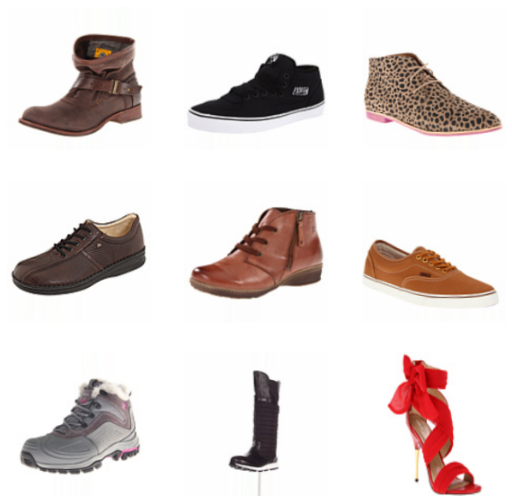

In [ ]:
dls.show_batch()

In [ ]:
#hide

# # lets grab a batch to have it handy for testing
#x,y,z = dls.one_batch()
#x.shape, y.shape,z[0].shape

## creating the VAE

Variational Auto-Encoder for fastai

I'm going to use a generic convolutional net as the basis of the encoder, and its reverse as the decoder. This is a proof of concept for using the _fastai_ framework, and will experiment with pre-trained resnet and MobileNet_v2 later. I'd like to use the MobileNet_v2 as a direct link ot the "SneakerFinder" tool which motivated this experiment. [see SneakerFinder]

A variational "module" will sit between the encoder and decoder as the "Bottleneck". The Bottleneck will map the resnet features into a latent space (e.g. ~100 dimensions) represented of standard normal variables.  The "reparameterizatoin trick" will sample from this space and the "decoder" will generate images. 

Finally a simple "decoder" will sample from the variational latents space and be trained to reconstruct the images. 

The intention is the latent space can be used to generate novel sneaker images.



### constructing VAE with Module Class Layers

For several of the decoder and "sampler" layers I might want to turn off the nonlinearity to give us more reasonable "gaussian" outputs to the Variational layer and the generated image which will is compared with the ImageNetStats batch-normalized image.

In [ ]:
#export

# this is the "Variational" magic.  aka the "reparamaterization trick"
class ReparamTricker(Module):
    def forward(self,mu,logvar):
        if True: #self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + eps * std
            return z
        else:
            return mu

class VAELinear(Module):
    def __init__(self,in_features,latent_features):
        self.fc_in = LinBnDrop(in_features,latent_features,bn=True,p=0.0,act=nn.ReLU(),lin_first=False)
        self.mu_linear = nn.Linear(latent_features,latent_features)
        self.logvar_linear = nn.Linear(latent_features,latent_features)

    def forward(self,x):
        h = self.fc_in(x)
        mu = self.mu_linear(h)
        logvar = self.logvar_linear(h)
        return mu,logvar

    
class VAELayer(Module):
    def __init__(self,in_features,latent_features):
        self.mu_logvar = VAELinear(in_features,latent_features)
        self.reparam = ReparamTricker()

    def forward(self,h):
        mu,logvar = self.mu_logvar(h)
        #logvar = F.softplus(logvar)   # force logvar>0
        z = self.reparam(mu,logvar) # adds the noise by the reparam trick
        return z, mu, logvar
    
            
class VAEBottleneck(Module):
    def __init__(self,input_dim,fc_dim,latent_dim,bn=True,drop_p=0.0,act=nn.ReLU()):
        self.bn = nn.Sequential(LinBnDrop(input_dim,fc_dim,bn=False),
                        VAELayer(in_features=fc_dim, out_features=latent_dim))

    def forward(self,h):
        # maybe assert that the shape is bs,encoder_features?
        z,mu,logvar = self.bn(h)
        return z, mu, logvar

In [ ]:
#export
class UpsampleBlock(Module):
    def __init__(self, up_in_c:int, final_div:bool=True, blur:bool=False, leaky:float=None, **kwargs):
        """
        up_in_c :  "Upsample input channel"
        """
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        ni = up_in_c//2
        nf = ni if final_div else ni//2
        self.conv1 = ConvLayer(ni, nf, **kwargs) # since we'llapply it by hand...
        self.conv2 = ConvLayer(nf, nf, **kwargs)

    def forward(self, up_in:Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        return self.conv2(self.conv1(up_out))
    
    def shuff(self,up_in:Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        cat_x = self.relu(up_out)
        return cat_x


### simple VAE class from VAE layer class components

once we have this we can do three things:

    1. develop proper VAE loss functions (including KL Divergence constraint on latent variables)
    2. create callbacks (and custom learner?) for training
    3. extend to a beta-variational framework with aims at creating "disentangled" latent dimensions
    

In [ ]:
#export

class VAE_rnet(Module):
    def __init__(self,bs=32, enc_dim=512, latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3],pretrained=True):
        #  drop_p=0.0 default turns off dropout
        
        self.im_size=im_size
        # encoder
        
        arch,cut = xresnet18(pretrained=True),-4
        self.encoder = nn.Sequential(*list(arch.children())[:cut],
                                   Flatten())
        
        base_d = 5 #img_size//(2**5) = img_size//32
        self.in_dim = enc_dim * base_d**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800
        # Sampling vector
        self.latent_dim = latent_dim

        n_blocks = 5        
        self.bn = VAELayer(self.in_dim,self.latent_dim)     

        fc_out = LinBnDrop(latent_dim,im_size*n_blocks*n_blocks,bn=False,p=0.0,act=nn.ReLU(),lin_first=True)

        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        self.decoder = nn.Sequential(fc_out,
                                ResizeBatch(im_size,n_blocks,n_blocks),
                                *modules,
                                ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None,
                                                #act_cls=nn.Sigmoid) )
                                             act_cls=partial(SigmoidRange, *out_range)))

    def decode(self, z):    
        z = self.decoder(z)
        return z
    
    def reparam(self, h):
        return self.bn(h)

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.reparam(h)
        return z, mu, logvar

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_hat = self.decode(z)
        latents = torch.stack([mu,logvar],dim=-1)
        return x_hat, latents # assume dims are [batch,latent_dim,concat_dim]

In [ ]:
resnet_vae = VAE_rnet(bs=batch_size,enc_dim=512)


In [ ]:
x,y,z = dls.one_batch()
x.shape,y.shape,z.shape

(torch.Size([64, 3, 160, 160]),
 torch.Size([64, 3, 160, 160]),
 torch.Size([64, 0, 2]))

In [ ]:
x_hat,latents = resnet_vae.cuda()(x)
x_hat.shape,latents.shape

(torch.Size([64, 3, 160, 160]), torch.Size([64, 128, 2]))

In [ ]:
mu, logvar = latents.split(1,dim=2)

KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(),1)

mu.shape,logvar.shape,KLD.shape,x_hat.shape,KLD.mean()

(torch.Size([64, 128, 1]),
 torch.Size([64, 128, 1]),
 torch.Size([64, 1]),
 torch.Size([64, 3, 160, 160]),
 tensor(5.5442, device='cuda:0', grad_fn=<MeanBackward0>))

In [ ]:
mse = MSELossFlat(reduction='sum')

er=mse(x,x_hat)
er,mu2.shape

(TensorBase(10229534., device='cuda:0', grad_fn=<AliasBackward>),
 torch.Size([32, 128]))

Sweet, we've verified the arcitecture works, but we need to train it with a loss that constrains the variational layers with the KL Divergence.  Otherwise the simple MSE will diverge.  

## VAE Loss functions classes

We have acouple examples to follow:  

    1. TabularData Vae (fastai v2 patterning) (@EtienneT)

~~pure PyTorch Vae which is directly related to our image dataset (@AntixK)~~

In [ ]:
#export

# called `after_batch`
class BVAELoss(Module):
    """
    Measures how well we have created the original image, 
    plus the KL Divergence with the unit normal distribution
    """
    def __init__(self, im_size, latent_dim, b_weight=None):
        mse = MSELossFlat(reduction='sum')
        if b_weight is None:
            # normalize to the mse and KLD have equalized magnitudes.
            #  we are summing over number of pixels and latent dimension
            b_weight = BETA * (3*im_size*im_size)/latent_dim #         
            # make small (mse ~ 1000*KLD) to start beta balancing the two losses
        store_attr('mse,im_size,latent_dim,b_weight')
        
    def forward(self, preds, *target):
        """
        pred =(x_hat,KLD,kl_weight) #mu,log_var, kl_weight)
        target is x (original) 
        """
        
        # this handles the annealed kl_weight and passing the mu,logvar around we added...
        if(len(preds) == 3):
            x_hat, latents, kl_weight = preds
        else: #if len(preds) == 2:  # we should never get here...
            x_hat, latents = preds
            
            kl_weight = x_hat[0].new(1)
            kl_weight[0] = 1.0
        
        #mu,logvar = latents[:,:,0],latents[:,:,1]
        mu, logvar = latents.split(1,dim=2)

        #note: both mse and KLD are summing errors over batches, and pixels or latents 
        total = self.mse(x_hat, target[0]) 
        
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        KLD = KLD.sum()*kl_weight
                
        return (total + self.b_weight*KLD)

    

The fastai `Learner` class does the training loop.  It took me a little digging into the code to figure out how Metrics are called since its not really stated anywhere in the documentation (_Note: create PR for fastai for extra documentation on `Metrics` logic_).  By default one of the key `Callbacks` is the `Recorder`.  It prints out the training summary at each epoch (via `ProgressCallBack`) and collects all the `Metrics`. Which by default only loss is a `train_met` and others are `valid_met`.
The `Recorder` resets (maps `reset()` to all mets) the metrics `before_train` and `before_valid`. The `Recorder` maps `accumulate()` to the metrics on `after_batch`.  Finally

In [ ]:
#export

# test: if i call them preds instead of vals might the Metric base class reset automatically?
class MyMetric(Metric):
    "for simple average over batch quantities"
    def reset(self):
        "Clear all targs and preds"
        self.vals = []
    @property
    def value(self):
        return np.array(self.vals).mean()

class MSEMetric(MyMetric):
    def __init__(self): 
        self.vals= []
    def accumulate(self, learn):
        x_hat = learn.pred[0]
        x_targs = learn.y[0]
        self.vals.append(  to_detach( F.mse_loss(x_hat, x_targs, reduction='sum') ))
    
class RawKLDMetric(MyMetric):
    def __init__(self): 
        self.vals = []
    def accumulate(self, learn):
        latents = learn.pred[1]                
        mu, logvar = latents.split(1,dim=2)
        KLD =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        self.vals.append(to_detach(KLD)) 
    
class BWeightedKLDMetric(MyMetric):
    def __init__(self,im_size,latent_dim): 
        self.vals = []
        self.b_weight = BETA*(3.*im_size*im_size)/latent_dim 
    def accumulate(self, learn):
        latents = to_detach(learn.pred[1])
        mu, logvar = latents.split(1,dim=2)

        # _,mu,logvar = to_detach(learn.pred)
        b_weight = self.b_weight/mu.shape[0]
        KLD = b_weight * -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        self.vals.append( KLD ) 

    
class MuMetric(MyMetric):
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        latents = to_detach(learn.pred[1])
        mu, logvar = latents.split(1,dim=2)
        self.vals.append(to_detach(mu.mean()))

    
class MuSDMetric(MyMetric):
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        latents = to_detach(learn.pred[1])
        mu, logvar = latents.split(1,dim=2)
        self.vals.append(to_detach(mu.std()))

    
class StdSDMetric(MyMetric):
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        latents = to_detach(learn.pred[1])
        mu, logvar = latents.split(1,dim=2)
        self.vals.append(to_detach((logvar).std()))

    
class StdMetric(MyMetric):
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        latents = to_detach(learn.pred[1])
        mu, logvar = latents.split(1,dim=2)
        self.vals.append(to_detach((logvar.exp_() ** .5).mean()))

        
class KLWeightMetric(MyMetric):
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        #kl = learn.model.kl_weight
        kl = learn.opt.hypers[0]['kl_weight']
        #KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        self.vals.append(kl) 


AnnealedLossCallback will inject the latent mu and logvar and a kl_weight variable into our loss.  The `mu` and `logvar` will be used to compute the KLD. The kl_weight is a scheduled weighting for the KLD. You can see the schedule graph of the parameter. At the beginning it will be 0, thus the KLD part of the loss will get ignored. So during 10% of training, we will fit a normal auto-encoder. Then gradually for 30% of trainning, increase kl_weight to 1 and then remain there for the remaining training time so that the auto encoder now becomes full variational. The way this callback is done, the loss will receive this parameter, but not the model.

In [ ]:
#export
        
class AnnealedLossCallback(Callback):
    def after_pred(self):
        kl = self.learn.pred[0].new(1)
        kl[0] = self.opt.hypers[0]['kl_weight']
        self.learn.pred = self.learn.pred + (kl,)
    def after_batch(self):
        pred, latents, _ = self.learn.pred
        self.learn.pred = (pred,latents)
        

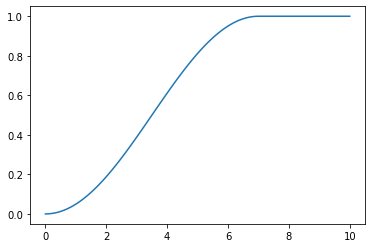

In [ ]:
# lets start with ~10 epochs of no KL regularizaiton, and ramp through the next 5
n_epochs = 10
f = combine_scheds([.7, .3], [SchedCos(0,1), SchedNo(1,1)])
# f = combine_scheds([.8, .2], [SchedCos(0,0), SchedCos(0,.5)])
p = torch.linspace(0.,1.,100)
pp = torch.linspace(0.,1.*n_epochs,100)

plt.plot(pp,[f(o) for o in p])

We'll make an config dictionary for us to use as a list of all hyper parameters. Also we avoid using early stopping because the AnnealedLossCallback will make the loss grow once the KL divergence weight kicks in.


In [ ]:
#export

# note that it is crucial that you don't freeze the batch norm layers... 
def bn_splitter(m):
    def _bn_splitter(l, g1, g2):
        if isinstance(l, nn.BatchNorm2d): g2 += l.parameters()
        elif hasattr(l, 'weight'): g1 += l.parameters()
        for ll in l.children(): _bn_splitter(ll, g1, g2)
        
    g1,g2 = [],[]
    _bn_splitter(m[0], g1, g2)
    
    g2 += m[1:].parameters()
    return g1,g2

def  resnetVAE_split(m): 
    to_freeze, dont_freeze = bn_splitter(m.encoder)
    #return L(to_freeze, dont_freeze + params(m.bn)+params(m.dec[:2]), params(m.dec[2:]))
    return L(to_freeze, dont_freeze + params(m.bn)+params(m.decoder))
    #return L(fz, nofz + params(m.bn)+params(m.dec[:6]), params(m.dec[6:]))
    


In [ ]:
latent_dim = 128

cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ParamScheduler({'kl_weight': f })]
metrics = [MSEMetric(), 
           RawKLDMetric(), 
           MuMetric(), 
           StdMetric(),
           BWeightedKLDMetric(IMG_SIZE,latent_dim),
           KLWeightMetric(), 
           MuSDMetric(), 
           StdSDMetric()]



I want to note something here that was a little confusing to me: `params(model)` is a builtin fastai `PyTorch.core` function which returns all of the parameters of the modules.    i.e.
    
```python    
def params(m):
    "Return all parameters of `m`"
    return [p for p in m.parameters()]
```


The toplevel `fastai core` functions with simple names that _almost_ match class attributes was one of my biggest stumbling blocks in getting acquainted with the fastai v2 API.  (The other is the documentation which is _autogenerated_ by the fastdev frameworks from their development noteboooks.  More on that struggle and my tips if that is troblesome for you later (here). 

Eventually we need to figure out how to make the `to_fp16()` callbacks work but for now we can fit the model in memory and deal with the slow (1min/epoch) training.


In [ ]:
resnet_vae = VAE_rnet(bs=batch_size,enc_dim=512)
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = BVAELoss(IMG_SIZE, latent_dim=latent_dim, b_weight=None)

learn = Learner(dls, resnet_vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=resnetVAE_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,


In [ ]:
#learn = learn.to_fp16()
learn.show_training_loop()


Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, ParamScheduler]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ParamScheduler]
         - after_pred     : [AnnealedLossCallback]
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, TerminateOnNaNCallback, AnnealedLossCallback, Recorder, ProgressCallback, ParamScheduler]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - aft

In [ ]:
# this freezes the resnet encoder (decoder = bottleneck + upsample)
learn.freeze()

(0.0005248074419796466,
 0.004365158267319202,
 0.0024449828546494246,
 0.0015135612338781357)

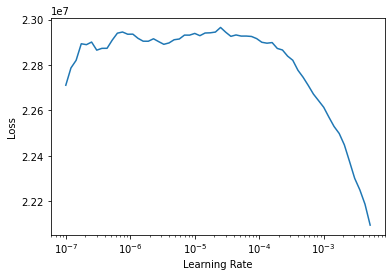

In [ ]:
lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# try default parameters before the lr_find results wihch are so inconsistent...
base_lr=gmlr #2e-3
freeze_epochs=10 #1

lr_mult=100
pct_start=0.3
div=5.0
    

epoch,train_loss,valid_loss,mse,raw_kld,mu,std,b_weighted_kld,kl_weight,mu_sd,std_sd,time
0,15960663.000000,14892005.000000,14834091.000000,10682.718750,0.055282,0.581494,10045.590820,0.049261,1.383588,0.890030,01:02
1,8312337.000000,6885769.000000,6734431.500000,12380.801758,0.022355,0.471349,11640.127930,0.187796,1.427237,0.918558,01:02
2,2387859.500000,2794598.250000,2396286.250000,16902.244141,-0.063848,0.473445,15896.976562,0.388167,1.737536,1.121041,01:02
3,1786101.875000,1895655.750000,1592893.750000,8188.931152,-0.068159,0.558976,7700.104980,0.610688,1.156518,0.766297,01:02
4,1683946.000000,1967873.250000,1539236.750000,8744.335938,-0.036991,0.558875,8218.119141,0.811285,1.192657,0.887429,01:02
5,1582125.000000,1659274.750000,1382597.875000,4816.957520,-0.027136,0.650064,4534.916504,0.950229,0.848015,0.754754,01:02
6,1478771.375000,1599873.750000,1325431.000000,4542.031738,-0.003371,0.667579,4276.231934,1.000000,0.794643,0.882437,01:02
7,1356691.750000,1382269.875000,1087969.875000,4877.927246,-0.020918,0.651937,4590.181152,1.000000,0.783198,1.045223,01:02
8,1258442.375000,1301305.625000,1030766.437500,4481.432617,-0.013590,0.669171,4216.571289,1.000000,0.736473,1.045089,01:02
9,1219878.125000,1270814.000000,1001933.062500,4455.008789,-0.015588,0.665986,4190.994141,1.000000,0.719571,1.072455,01:02


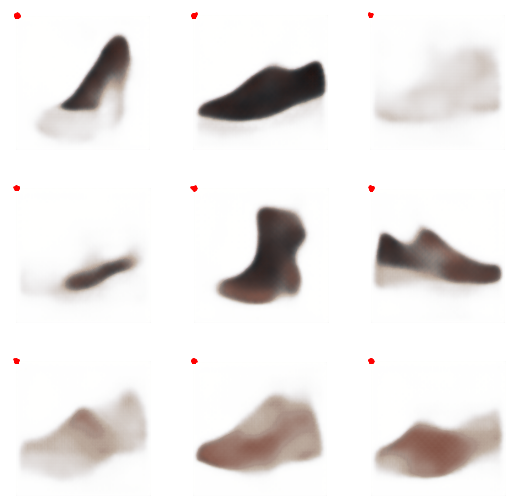

In [ ]:
#fit the backend of the VAE (n)
learn.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.5)
learn.show_results()

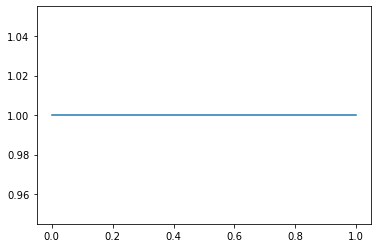

In [ ]:
# replace kl_weight scheduler... 
learn.remove_cb(learn.cbs[-1])
# add new scheduler
f = SchedNo(1.,1.)  #is "f" still referenced by the scheduler?
learn.add_cb(ParamScheduler({'kl_weight': f }) )
#ParamScheduler({'kl_weight': SchedNo(1.,1.) })
#f = sched_no(1.,1.)  #is "f" still referenced by the scheduler?

p = torch.linspace(0.,1.,100)
plt.plot(p,[f(o) for o in p])

In [ ]:
learn.cbs

(#6) [TrainEvalCallback,Recorder,ProgressCallback,AnnealedLossCallback,TerminateOnNaNCallback,ParamScheduler]

In [ ]:
lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr

In [ ]:
epochs = 5
base_lr = gmlr #/= 2
epochs = 200
learn.unfreeze()
learn.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div)

learn.show_results()

epoch,train_loss,valid_loss,mse,raw_kld,mu,std,b_weighted_kld,kl_weight,mu_sd,std_sd,time
0,21774.650391,22650.550781,19511.349609,51.812107,0.008700,0.780547,3118.117920,1.000000,0.575428,1.299118,01:02
1,21190.279297,21741.263672,18716.884766,49.920315,0.014094,0.784651,3004.746582,1.000000,0.549279,1.308946,01:02
2,20879.044922,21005.876953,17937.744141,50.672169,0.020091,0.780762,3049.189697,1.000000,0.561731,1.294866,01:02
3,20417.935547,21104.996094,17990.638672,51.415028,0.029331,0.792147,3093.975098,1.000000,0.558953,1.351698,01:02
4,20213.500000,20804.699219,17871.443359,48.409683,0.022852,0.790175,2913.135742,1.000000,0.542671,1.284989,01:02
5,20185.697266,20345.017578,17426.511719,48.179798,0.021902,0.801088,2899.371826,1.000000,0.539924,1.304452,01:02
6,19787.281250,19923.361328,16574.333984,55.376236,0.009115,0.787731,3332.596924,1.000000,0.549799,1.517726,01:02
7,19540.693359,20182.431641,17226.962891,48.806915,0.017856,0.802754,2937.343506,1.000000,0.530039,1.361129,01:02
8,19541.896484,20044.033203,16793.751953,53.714359,0.023700,0.795316,3232.257812,1.000000,0.549011,1.480833,01:02
9,19450.349609,19519.679688,16417.074219,51.267471,0.006715,0.808640,3085.528076,1.000000,0.543418,1.424417,01:02


KeyboardInterrupt: 

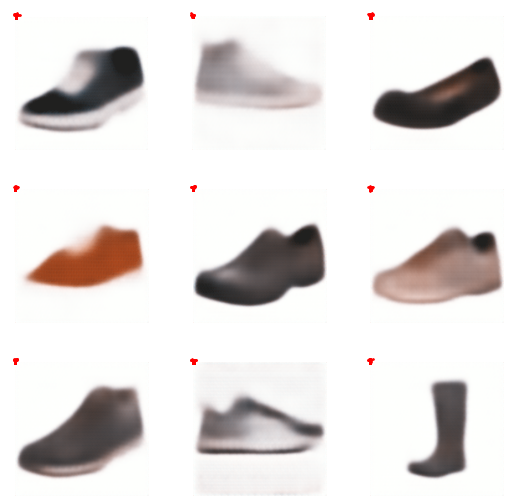

In [ ]:
learn.show_results()
#learn.save('VAE_finetune_by_hand-fep18_ep200')

epoch,train_loss,valid_loss,mse,raw_kld,mu,std,b_weighted_kld,kl_weight,mu_sd,std_sd,time
0,13256.858398,14557.280273,9813.398438,78.725296,-0.008567,0.738959,4736.696289,1.000000,0.580555,1.613991,01:02
1,13171.897461,13844.900391,9769.145508,67.631569,-0.003443,0.738907,4070.906250,1.000000,0.575456,1.589602,01:02
2,13242.020508,14023.041016,9835.143555,69.490623,-0.003357,0.737869,4182.403809,1.000000,0.573735,1.607599,01:02
3,13153.906250,13892.381836,9809.009766,67.756409,-0.003757,0.739861,4078.372803,1.000000,0.577188,1.595389,01:02
4,13247.565430,13886.603516,9723.559570,69.082596,-0.003815,0.736579,4158.187012,1.000000,0.575983,1.626789,01:02
5,13175.669922,14005.883789,9849.165039,68.970467,-0.004627,0.739190,4151.445801,1.000000,0.578317,1.601909,01:02
6,13236.111328,13878.837891,9779.439453,68.022346,-0.001400,0.738487,4094.460449,1.000000,0.575536,1.599865,01:02
7,13186.297852,13820.747070,9722.049805,68.020668,-0.008243,0.738318,4094.503174,1.000000,0.577651,1.600041,01:02
8,13137.218750,13935.554688,9837.960938,67.992340,-0.002487,0.738172,4092.450684,1.000000,0.574274,1.601892,01:02
9,13285.389648,13925.652344,9837.024414,67.839432,-0.002822,0.737976,4083.427490,1.000000,0.575611,1.585492,01:02


Path('models/VAE_finetune_by_hand-fep18_ep400.pth')

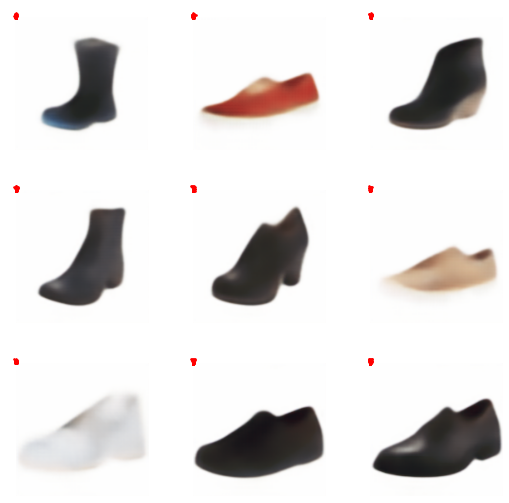

In [ ]:
epochs = 200
learn.unfreeze()
learn.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div)

learn.show_results()

learn.save('VAE_finetune_by_hand-fep18_ep400')

##  other VAE flavors

1. MobileNet_v2 as the encoder, as a continuation of the original Sneaker Finder

2. linear deterministic Auto Encoder... removing the variational layer and just having it be an excercise in encoding -- a great baseline.

3. simple bowtie convolutional encoder / decoder
    - a. variational 
    - b. deterministic


In [ ]:
#export
def trns_mobilenet_v2():
    model_conv = torchvision.models.mobilenet_v2(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default
    # just read this off: model_conv.classifier
    num_ftrs = model_conv.classifier._modules['1'].in_features
    model_conv.classifier._modules['1'] = nn.Linear(num_ftrs, num_categories)
    
    return model_conv

# check enc_dim... 
class VAE_mnet(Module):
    def __init__(self,bs=32, latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3],pretrained=True):
        #  drop_p=0.0 default turns off dropout, removed enc_dim=512
        
        self.im_size=im_size
        # encoder
        
        
        # need to make the mnet and cut here...        
        arch,cut = torchvision.models.mobilenet_v2(pretrained=True),-1
        enc_dim = arch.classifier._modules['1'].in_features
        
        self.enc = nn.Sequential(*list(arch.children())[:cut],
                                   Flatten())
        

        base_d = 5 #img_size//(2**5) = img_size//32
        self.in_dim = enc_dim * base_d**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800
        # Sampling vector
        self.latent_dim = latent_dim


        n_blocks = 5        
        self.bn = VAELayer(self.in_dim,self.latent_dim)     

        fc_out = LinBnDrop(latent_dim,im_size*n_blocks*n_blocks,bn=False,p=0.0,act=nn.ReLU(),lin_first=True)

        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        self.dec = nn.Sequential(fc_out,
                                 ResizeBatch(im_size,n_blocks,n_blocks),
                                *modules,
                                ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None,
                                                #act_cls=nn.Sigmoid) )
                                             act_cls=partial(SigmoidRange, *out_range)))
        #error parameters
        self.mu = Tensor([bs,latent_dim])
        self.logvar =  Tensor([bs,latent_dim])


    def reparam(self, h):
        z, mu, logvar = self.bn(h)
        self.mu = mu
        self.logvar = logvar

        return z
            
    def forward(self, x):
        h = self.enc(x)
        z = self.reparam(h)
        x_reconst = self.dec(z)

        return x_reconst #, z, mu, logvar

In [ ]:
#export

# note that it is crucial that you don't freeze the batch norm layers... 
def bn_splitter(m):
    def _bn_splitter(l, g1, g2):
        if isinstance(l, nn.BatchNorm2d): g2 += l.parameters()
        elif hasattr(l, 'weight'): g1 += l.parameters()
        for ll in l.children(): _bn_splitter(ll, g1, g2)
        
    g1,g2 = [],[]
    _bn_splitter(m[0], g1, g2)
    
    g2 += m[1:].parameters()
    return g1,g2

def mnetV2_split(m): 
    to_freeze, dont_freeze = bn_splitter(m.enc)
    #return L(to_freeze, dont_freeze + params(m.bn)+params(m.dec[:2]), params(m.dec[2:]))
    return L(to_freeze, dont_freeze + params(m.bn)+params(m.dec))
    #return L(fz, nofz + params(m.bn)+params(m.dec[:6]), params(m.dec[6:]))
    


## ResNet AutoEncoder (deterministic)

In [ ]:
#export

class AE_rnet(Module):
    def __init__(self,bs=32, enc_dim=512, latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3],pretrained=True):
        #  drop_p=0.0 default turns off dropout
        
        self.im_size=im_size
        # encoder
        
        arch,cut = xresnet18(pretrained=True),-4
        self.enc = nn.Sequential(*list(arch.children())[:cut],
                                   Flatten())
        

        base_d = 5 #img_size//(2**5) = img_size//32
        self.in_dim = enc_dim * base_d**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800
        # Sampling vector
        self.latent_dim = latent_dim


        n_blocks = 5  
        #         self.bn = VAELayer(self.in_dim,self.latent_dim)     
        fc_in = LinBnDrop(self.in_dim,latent_dim,bn=False,p=0.0,act=nn.ReLU(),lin_first=True)
        fc_out = LinBnDrop(latent_dim,im_size*n_blocks*n_blocks,bn=False,p=0.0,act=nn.ReLU(),lin_first=True)

        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        self.dec = nn.Sequential(fc_in,
                                 fc_out,
                                 ResizeBatch(im_size,n_blocks,n_blocks),
                                 *modules,
                                 ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None,
                                                #act_cls=nn.Sigmoid) )
                                             act_cls=partial(SigmoidRange, *out_range)))

            
    def forward(self, x):
        h = self.enc(x)
        x_reconst = self.dec(h)

        return x_reconst #, z, mu, logvar

In [ ]:
#export

# # deterministic autoencoder...
# rnet_ae = nn.Sequential(rnet_body, rnet_dec)


# check enc_dim... 
class AE_mnet(Module):
    def __init__(self,bs=32, latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3],pretrained=True):
        #  drop_p=0.0 default turns off dropout, removed enc_dim=512
        
        self.im_size=im_size
        # encoder
        
        
        # need to make the mnet and cut here...        
        arch,cut = torchvision.models.mobilenet_v2(pretrained=True),-1
        enc_dim = arch.classifier._modules['1'].in_features
        
        self.enc = nn.Sequential(*list(arch.children())[:cut],
                                   Flatten())
        

        base_d = 5 #img_size//(2**5) = img_size//32
        self.in_dim = enc_dim * base_d**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800
        # Sampling vector
        self.latent_dim = latent_dim


        n_blocks = 5        
        self.bn = VAELayer(self.in_dim,self.latent_dim)     

        fc_out = LinBnDrop(latent_dim,im_size*n_blocks*n_blocks,bn=False,p=0.0,act=nn.ReLU(),lin_first=True)

        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        self.dec = nn.Sequential(fc_out,
                                 ResizeBatch(im_size,n_blocks,n_blocks),
                                *modules,
                                ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None,
                                                #act_cls=nn.Sigmoid) )
                                             act_cls=partial(SigmoidRange, *out_range)))
        #error parameters
        self.mu = Tensor([bs,latent_dim])
        self.logvar =  Tensor([bs,latent_dim])


    def reparam(self, h):
        z, mu, logvar = self.bn(h)
        self.mu = mu
        self.logvar = logvar

        return z
            
    def forward(self, x):
        h = self.enc(x)
        z = self.reparam(h)
        x_reconst = self.dec(z)

        return x_reconst #, z, mu, logvar
    

## replace latent regularization term in loss_fn (KLD) with MME 

In [ ]:
#hide
class BVAELoss(Module):
    """
    Measures how well we have created the original image, 
    plus the KL Divergence with the unit normal distribution
    """
    def __init__(self, im_size, latent_dim, bs=32, b_weight=None):
        mse = MSELossFlat(reduction='sum')
        if b_weight is None:
            # normalize to the mse and KLD have equalized magnitudes.
            #  we are summing over number of pixels and latent dimension
            b_weight = BETA * (3*im_size*im_size)/latent_dim #         
            # make small (mse ~ 1000*KLD) to start beta balancing the two losses
        store_attr('mse,im_size,latent_dim,b_weight,bs')
        
    def forward(self, preds, target):
        """
        pred =(x_hat,KLD,kl_weight) #mu,log_var, kl_weight)
        x_target is x (original) 
        """
        # this handles the annealed kl_weight and passing the mu,logvar around we added...
        if(len(preds) == 4):
            x_hat, mu,logvar, kl_weight = preds
        else: #if len(preds) == 1:  # we should never get here...
            x_hat = preds
            
            mu = x_hat[0].new(1)
            mu[0] = 0.0
            
            logvar = x_hat[0].new(1)
            logvar[0] = 0.0
            
            kl_weight = x_hat[0].new(1)
            kl_weight[0] = 1.0
        
        #note: both mse and KLD are summing errors over batches, and pixels or latents 
        total = self.mse(x_hat, target)/self.bs 
        
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        KLD = KLD.sum()*kl_weight/self.bs
                
        return (total + self.b_weight*KLD)
        
def compute_kernel(x, y):
    x_size = x.shape[0]
    y_size = y.shape[0]
    dim = x.shape[1]

    tiled_x = x.view(x_size,1,dim).repeat(1, y_size,1)
    tiled_y = y.view(1,y_size,dim).repeat(x_size, 1,1)

    return torch.exp(-torch.mean((tiled_x - tiled_y)**2,dim=2)/dim*1.0)


def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return torch.mean(x_kernel) + torch.mean(y_kernel) - 2*torch.mean(xy_kernel)


class VAERecreatedLoss(Module):
    "Measures how well we have created the original tabular inputs, plus the KL Divergence with the unit normal distribution"
    def __init__(self, cat_dict, dataset_size, bs, hidden_size, mmd_weight = 1000, reduction='mean'):
        ce = CrossEntropyLossFlat(reduction='none')
        mse = MSELossFlat(reduction='none')
        store_attr('cat_dict,ce,mse,dataset_size,bs,hidden_size,mmd_weight,reduction')
        
    def forward(self, preds, cat_targs, cont_targs):
        if(len(preds) == 4):
            cats,conts, z, kl_weight = preds
        else:
            cats,conts, z = preds
            kl_weight = 1
            
        true_samples = torch.randn((cats.shape[0],self.hidden_size))
        true_samples = nn.Parameter(true_samples).cuda()

        tot_ce, pos = [], 0
        for i, (k,v) in enumerate(self.cat_dict.items()):
            tot_ce += [self.ce(cats[:, pos:pos+v], cat_targs[:,i])]
            pos += v

        tot_ce = torch.stack(tot_ce, dim=1).mean(dim=1)
        cont_loss = self.mse(conts, cont_targs).view(conts.shape).mean(dim=1)
        recons_loss = (tot_ce + cont_loss)
        
        mmd_loss = compute_mmd(true_samples, z).repeat(cats.shape[0])
        
        total_loss = recons_loss + (mmd_loss * self.mmd_weight)
        
        if self.reduction == 'mean':
            return total_loss.mean()
        elif self.reduction == 'sum':
            return total_loss.sum()

        return total_loss
        
class MSEMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        cats, conts, z = learn.pred
        cat_targs, cont_targs = learn.y
        norm_conts = conts.new([conts.size(1)])
        self.preds.append(to_detach(F.mse_loss(conts, cont_targs, reduction='sum') / norm_conts))
    @property
    def value(self):
        return np.array(self.preds).mean()
    

class MMDMetric(Metric):
    def __init__(self): self.preds = []
    def accumulate(self, learn):
        cats, conts, z = learn.pred
        true_samples = torch.randn((bs,config['hidden_size']))
        true_samples = nn.Parameter(true_samples).cuda()
        MMD = compute_mmd(true_samples, z)
        self.preds.append(to_detach(MMD))
    @property
    def value(self):
        return np.array(self.preds).mean()        

In [ ]:
#hide
def gaussian_kernel(a, b):
    dim1_1, dim1_2 = a.shape[0], b.shape[0]
    depth = a.shape[1]
    a = a.view(dim1_1, 1, depth)
    b = b.view(1, dim1_2, depth)
    a_core = a.expand(dim1_1, dim1_2, depth)
    b_core = b.expand(dim1_1, dim1_2, depth)
    numerator = (a_core - b_core).pow(2).mean(2)/depth
    return torch.exp(-numerator)

def MMD(a, b):
    return gaussian_kernel(a, a).mean() + gaussian_kernel(b, b).mean() - 2*gaussian_kernel(a, b).mean()

In [ ]:
#hide
def MMEloss_function(pred, true, latent):
    return (pred-true).pow(2).mean(), MMD(torch.randn(200, LATENT_SIZE, requires_grad = False).to(DEVICE), latent)

In [ ]:
#hide

class Reshape(nn.Module):
    '''
        Used in a nn.Sequential pipeline to reshape on the fly.
    '''
    def __init__(self, *target_shape):
        super().__init__()
        self.target_shape = target_shape
    
    def forward(self, x):
        return x.view(*self.target_shape)

class MMD_VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 5, kernel_size = 5, padding = 2), #1*28*28 -> 5*28*28
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 5, out_channels = 5, kernel_size = 5), #5*28*28 -> 5*24*24
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 5, out_channels = 5, kernel_size = 5), #5*24*24 -> 5*20*20
            nn.LeakyReLU(),
            Reshape([-1,5*20*20]),
            nn.Linear(in_features = 5*20*20, out_features = 5*12),
            nn.LeakyReLU(),
            nn.Linear(in_features = 5*12, out_features = LATENT_SIZE)
        )

        self.decoder = nn.Sequential(
            nn.Linear(in_features = LATENT_SIZE, out_features = 5*12),
            nn.ReLU(),
            nn.Linear(in_features = 5*12, out_features = 24*24),
            nn.ReLU(),
            Reshape([-1,1,24,24]),
            nn.ConvTranspose2d(in_channels = 1, out_channels = 5, kernel_size = 3), #1*24*24 -> 5*26*26
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 5, out_channels = 10, kernel_size = 5), #5*26*26 -> 10*30*30
            nn.ReLU(),
            nn.Conv2d(in_channels = 10, out_channels = 1, kernel_size = 3), #10*30*30 -> 1*28*28
            nn.Sigmoid()
        )
    
    def forward(self, X):
        if self.training:
            latent = self.encoder(X)
            return self.decoder(latent), latent
        else:
            return self.decoder( self.encoder(X) )

In [ ]:
#hide

from nbdev.export import notebook2script
notebook2script()


[autoreload of snkrfinder.core failed: Traceback (most recent call last):
  File "/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/ergonyc/Projects/Project2.0/snkr-finder/nbs/snkrfinder/core.py", line 14, in <module>
    from nbdev.showdoc 

Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted 02a_model.ipynb.
Converted 02b_model.transfer.ipynb.
Converted 03_cvae.ipynb.
Converted 04_widgets.ipynb.
Converted index.ipynb.
